# Solving Characteristic equation of HE Modes

In [128]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
from scipy.special import jv, kv, jn_zeros
from scipy.optimize import fsolve

## HE mode equation

$$
\begin{align}
\sqrt{
	\left[
			uw^2\,\frac{J_{q-1}(u)}{J_q(u)} 
			- u^2w\,\frac{K_{q-1}(w)}{K_q(w)}
			- q\,V^2
	\right]
	\left[
			\left(\frac{n_1}{n_2}\right)^2  uw^2\,\frac{J_{q-1}(u)}{J_q(u)} 
			- u^2w\,\frac{K_{q-1}(w)}{K_q(w)}
			- q \left\{
					\left(\frac{n_1}{n_2}\right)^2 w^2 + u^2
				 \right\}
	\right]
} \\
+q\,
\sqrt{
V^2 \left\{ \left( \frac{n_1}{n_2} \right)^2 w^2 + u^2 \right\} 
} = 0
\end{align}
$$

풀어야 할 HE 모드 방정식을 함수 형태로 정리한다.  

In [129]:
def gen_eigen_eq(n1, n2, q, **kwargs):
    
    def eq_he(u):
        w = np.sqrt(v*v - u*u)
        N = (n1/n2)**2
        J = jv(q-1,u)/jv(q,u)
        K = kv(q-1,w)/kv(q,w)
        A = u*w*w*J - u*u*w*K - q*v*v
        B = N*u*w*w*J - u*u*w*K - q*(N*w*w + u*u)
        C = q*q*v*v*(N*w*w + u*u)
        return np.sqrt(A*B) + np.sqrt(C)

    if kwargs.get("mode")=="HE":
        return eq_he

In [139]:
v = 10
q=1
u = np.linspace(0.0001, v, 10)
w = np.sqrt(v*v - u*u)
J = u*w*w*jv(q-1, u)/jv(q, u)
K = u*u*w*kv(q-1, w)/kv(q, w)
Q = q*v*
print(J-K)

[  199.99999963   153.64577005    -8.39627828  -602.91971418
   382.70551065  -256.14008615 -1302.11936661   -10.39524519
  -373.13543288            nan]


C:\Users\jkkow\AppData\Local\Temp\ipykernel_6528\558969353.py:6: RuntimeWarning: invalid value encountered in multiply
  K = u*u*w*kv(q-1, w)/kv(q, w)


## Graphical Soulution of HE mode

Graphical solution을 구하기 위해 `scipy.optimize`모듈의 함수 `fsolve()`를 사용한다.  
이때의 주요 문제는 다양한 V 값에 대해 모든 해를 오류없이 구하기 위한 '초기값' 설정이다.  
이 초기값만 잘 설정해 줄 수 있으면 `fsolve()`함수로 무리없이 방정식의 근을 구할 수 있다.

### Getting asymtotic points

올바른 해를 얻기 위한 수치계산 초기값 설정에는 eigenvalue equation이 발산하는 지점을 아는 것이 중요하다.  
이 발산점들을 향해 eigenvalue eq.는 점근(asymtote)한다.  
다음에 주어진 V 값에 대한 방정식의 모든 점근선 위치를 반환하는 함수를 정의한다.  

먼저 주어진 V 값에 대해 몇 개의 발산 포인트가 있는지 계산해주는 함수를 만들고,

In [131]:
def num_of_zeros_jn(v, q) -> int:
  count: int = 1
  while jn_zeros(q, count)[-1] < v:
    count += 1
    if count > 100:
      raise ValueError("Too many points of Bessel zeros")
  num = count - 1 
  return num

이를 이용해 asymtotic_point를 구하는 함수를 다음과 같이 정의할 수 있다.

In [132]:
def get_asymtotic_points(v, q) -> list:
  num: int = num_of_zeros_jn(v, q)
  if num ==0:
    return None
  else:
    asymtotic_points = jn_zeros(q, num)
    return asymtotic_points

### Define plotting funtion to analysis

다음과 같이 eigenvalue equation 전체를 plot하는 함수를 정의하여 분석에 이용한다. 

In [136]:
def plot_eigen_eq(v, n1, n2, q):
  fig, axe = plt.subplots()

  delta = 0.000001
  u = np.linspace(delta, v-delta, int(v*50000))
  eigen = gen_eigen_eq(n1, n2, q, mode='HE')
  eq = eigen(u)

  label = f"Square of eigen eq. HE"

  # Limits plot range by setting values over 1.2V as 'None'
  plot_limit = 1000
  meq = np.where(abs(eq) >= plot_limit, None, eq)

  axe.set_title(r"$HE_{qm}$ modes" + f" @V={v:.4f}, q={q}")
  axe.plot(u, meq, color='green', label=label) # plot eigen-value eq.
  axe.hlines(y=0, xmin=0, xmax=v, colors='k') # plot x axis.
  axe.set_xlabel("$u$")
  axe.set_ylim(-plot_limit, plot_limit)
  axe.xaxis.set_minor_locator(AutoMinorLocator(5))
  axe.legend(loc=2)

  # plot diverging assymtotic lines
  asymtotic_lines = get_asymtotic_points(v, q=0)
  print(f"asymtotic_lines={asymtotic_lines}")
  plt.vlines(x=asymtotic_lines, ymin=-plot_limit, ymax=plot_limit, linestyles='dashed', colors='k', alpha=0.5, linewidth=0.9)

  return axe

asymtotic_lines=[2.40482556]


<Axes: title={'center': '$HE_{qm}$ modes @V=3.0000, q=2'}, xlabel='$u$'>

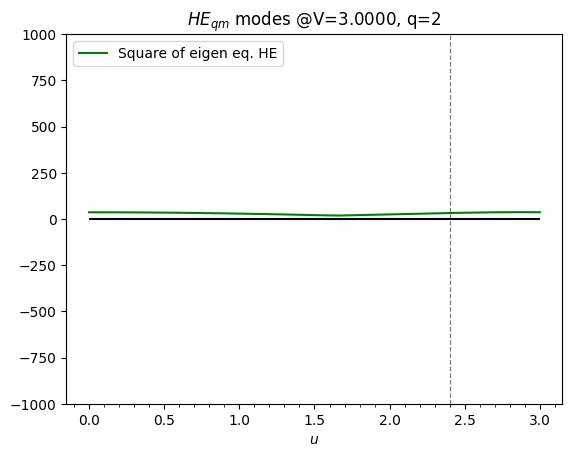

In [140]:
v = 3
n2 = 1.444
na = 0.22
# n1 = (na/n2)**2 + 1
n1 = n2
q = 2
plot_eigen_eq(v, n1, n2, q)

### Initial values to get numerical solutions

그래프를 그려가며 분석한 결과 V 값이 방정식의 점근선에 가까울 때 마지막 근의 경우  
그래프가 급격히 변화하여 `RuntimeWarning`이 발생한다.  
이와 같은 경우는 다음과 같이 마지막 초기값을 점근선과 V값의 중앙 값으로 하여 해결할 수 있다.

In [135]:
def get_init_points_to_solve(v, q):
  asymtotic_points = get_asymtotic_points(v, q)
  if asymtotic_points is not None:
    offset = (v - asymtotic_points[-1])/2 # critical to avoide RuntimeWarning
    init_points = asymtotic_points + offset
    return init_points
  else:
    return None

### Function to get list of solutions

위의 함수로 수치해를 풀 초기값을 설정한 후 다음 함수로 해집합을 에러 없이 구할 수 있다.